In [1]:
import os
import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)

Welcome to ROOTaaS 6.05/02


/swshare/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/swshare/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


<module 'training_utils' from '/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.pyc'>

In [2]:
ntuples = '20170509'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s]
diphotonJets = [s for s in files if "DiPhotonJets" in s]
gJets = [s for s in files if "GJet" in s]

utils.IO.add_signal(ntuples,signal)
utils.IO.add_background(ntuples,diphotonJets)
utils.IO.add_background(ntuples,gJets)
for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509
using background file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/output_GJet_total.root
using signal file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/AllNonResSig.root


In [45]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
branch_names = 'leadingJet_bDis,subleadingJet_bDis,CosThetaStar_CS,CosTheta_bb,CosTheta_gg,noexpand:diphotonCandidate.Pt(),noexpand:dijetCandidate.Pt(),noexpand:diHiggsCandidate.M()'.split(",")
branch_names = [c.strip() for c in branch_names]
branch_names = (b.replace(" ", "_") for b in branch_names)
branch_names = list(b.replace("-", "_") for b in branch_names)
print branch_names

import pandas as pd
import root_pandas as rpd

signal_df = []
background_df = []
weights_sig = []
weights_bkg = []

w_sig = []
w_bkg = []

w_sig.append(1)
w_bkg.append(0.5)
w_bkg.append(0.7)

shuffle = True



for i in range(utils.IO.nSig):
    signal_df.append(rpd.read_root(utils.IO.signalName[i],"bbggSelectionTree", columns = branch_names))
    if shuffle:
        signal_df[i]['random_index'] = np.random.permutation(range(signal_df[i].index.size))
        signal_df[i].sort_values(by='random_index',inplace=True)

    utils.preprocessing.adjust_and_compress(signal_df[i]).to_hdf('/tmp/micheli/signal.hd5','sig',compression=9,complib='bzip2',mode='a')
    utils.preprocessing.define_process_weight(signal_df[i],i+1,w_sig[i])

for i in range(utils.IO.nBkg):
    background_df.append(rpd.read_root(utils.IO.backgroundName[i],"bbggSelectionTree", columns = branch_names))
    if shuffle:
        background_df[i]['random_index'] = np.random.permutation(range(background_df[i].index.size))
        background_df[i].sort_values(by='random_index',inplace=True)
    utils.preprocessing.adjust_and_compress(background_df[i]).to_hdf('/tmp/micheli/background.hd5','bkg',compression=9,complib='bzip2',mode='a')
    utils.preprocessing.define_process_weight(background_df[i],-(i+1),w_bkg[i])
    
for i in range(utils.IO.nSig):
    if i ==0:
        y_sig = signal_df[i][['proc']]
        X_sig= np.concatenate([signal_df[i][['leadingJet_bDis','subleadingJet_bDis']],
                             np.divide(signal_df[i][['diphotonCandidate.Pt()']],signal_df[0][['diHiggsCandidate.M()']]),
                             np.divide(signal_df[i][['dijetCandidate.Pt()']],signal_df[0][['diHiggsCandidate.M()']]),
                             np.absolute(signal_df[i][['CosThetaStar_CS']]),
                             np.absolute(signal_df[i][['CosTheta_bb']]),
                             np.absolute(signal_df[i][['CosTheta_gg']])],
                             axis=1)
        weights_sig = signal_df[i][['weight']]
    else:
        y_sig = np.concatenate((y_sig,signal_df[i][['proc']]))
        X_sig= np.concatenate((X_sig,np.concatenate([signal_df[i][['leadingJet_bDis','subleadingJet_bDis']],
                             np.divide(signal_df[i][['diphotonCandidate.Pt()']],signal_df[i][['diHiggsCandidate.M()']]),
                             np.divide(signal_df[i][['dijetCandidate.Pt()']],signal_df[i][['diHiggsCandidate.M()']]),
                             np.absolute(signal_df[i][['CosThetaStar_CS']]),
                             np.absolute(signal_df[i][['CosTheta_bb']]),
                             np.absolute(signal_df[i][['CosTheta_gg']])],
                             axis=1)))    
        weights_sig = np.concatenate((weights_sig,signal_df[i][['weight']]))
    
for i in range(utils.IO.nBkg):
    if i ==0:
        y_bkg = background_df[i][['proc']]
        X_bkg= np.concatenate([background_df[0][['leadingJet_bDis','subleadingJet_bDis']],
                             np.divide(background_df[0][['diphotonCandidate.Pt()']],background_df[0][['diHiggsCandidate.M()']]),
                             np.divide(background_df[0][['dijetCandidate.Pt()']],background_df[0][['diHiggsCandidate.M()']]),
                             np.absolute(background_df[0][['CosThetaStar_CS']]),
                             np.absolute(background_df[0][['CosTheta_bb']]),
                             np.absolute(background_df[0][['CosTheta_gg']])],
                             axis=1)
        weights_bkg = background_df[i][['weight']]


    else:
        y_bkg = np.concatenate((y_bkg,background_df[i][['proc']]))
        
        X_bkg= np.concatenate((X_bkg,np.concatenate([background_df[i][['leadingJet_bDis','subleadingJet_bDis']],
                             np.divide(background_df[i][['diphotonCandidate.Pt()']],background_df[i][['diHiggsCandidate.M()']]),
                             np.divide(background_df[i][['dijetCandidate.Pt()']],background_df[i][['diHiggsCandidate.M()']]),
                             np.absolute(background_df[i][['CosThetaStar_CS']]),
                             np.absolute(background_df[i][['CosTheta_bb']]),
                             np.absolute(background_df[i][['CosTheta_gg']])],axis=1)))
        weights_bkg = np.concatenate((weights_bkg,background_df[i][['weight']]))

#FIXME!!!!!scrivi metodo
randomize = np.arange(len(X_bkg))
np.random.shuffle(randomize)
X_bkg = X_bkg[randomize]
y_bkg = y_bkg[randomize]
weights_bkg = weights_bkg[randomize]


randomize = np.arange(len(X_sig))
np.random.shuffle(randomize)
X_sig = X_sig[randomize]
y_sig = np.asarray(y_sig)[randomize]
weights_sig = np.asarray(weights_sig)[randomize]


#FIXME!!!!!metti i casting nel metodo (magari anche il ravel)
#for i in range(utils.IO.nSig):
y_total_train = utils.preprocessing.get_total_training_sample(pd.DataFrame(y_sig),pd.DataFrame(y_bkg)).ravel()
X_total_train = utils.preprocessing.get_total_training_sample(pd.DataFrame(X_sig),pd.DataFrame(X_bkg))

y_total_test = utils.preprocessing.get_total_test_sample(pd.DataFrame(y_sig),pd.DataFrame(y_bkg)).ravel()
X_total_test = utils.preprocessing.get_total_test_sample(pd.DataFrame(X_sig),pd.DataFrame(X_bkg))

w_total_train = utils.preprocessing.get_total_training_sample(pd.DataFrame(weights_sig),pd.DataFrame(weights_bkg)).ravel()
w_total_test = utils.preprocessing.get_total_test_sample(pd.DataFrame(weights_sig),pd.DataFrame(weights_bkg)).ravel()

['leadingJet_bDis', 'subleadingJet_bDis', 'CosThetaStar_CS', 'CosTheta_bb', 'CosTheta_gg', 'noexpand:diphotonCandidate.Pt()', 'noexpand:dijetCandidate.Pt()', 'noexpand:diHiggsCandidate.M()']


In [39]:
import xgboost as xgb
#####FIXME!!!!!just for speed test, reset parameters
clf = xgb.XGBClassifier(max_depth=10,learning_rate=0.2,n_estimators=500, min_child_weight=1e-5, nthread= 12)
#clf = ensemble.GradientBoostingClassifier(max_depth=10,learning_rate=0.1,n_estimators=200,verbose=1)
clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1e-05, missing=None, n_estimators=500, nthread=12,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

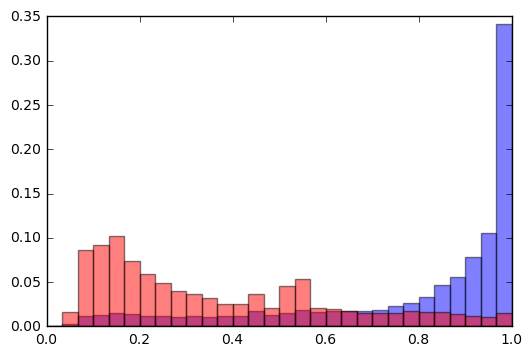

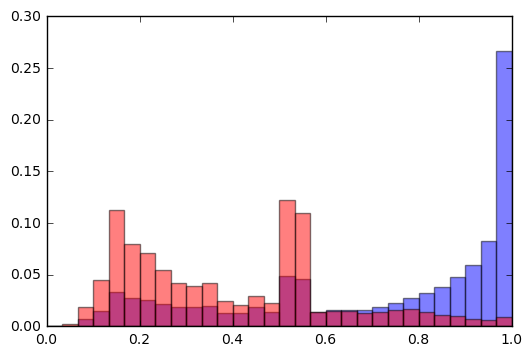

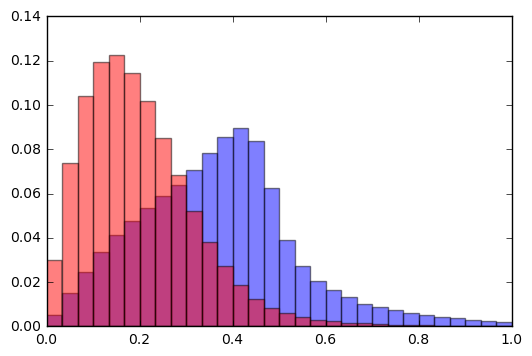

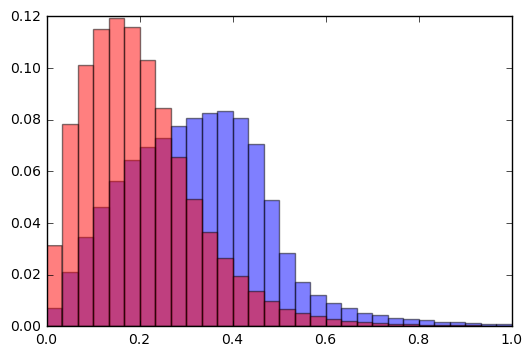

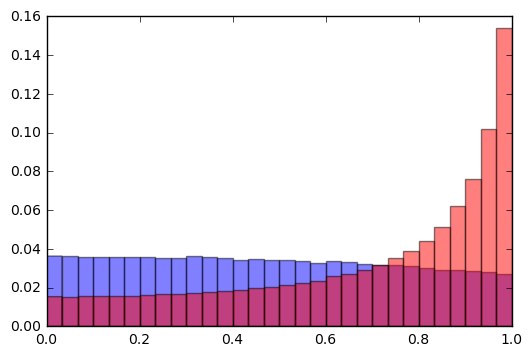

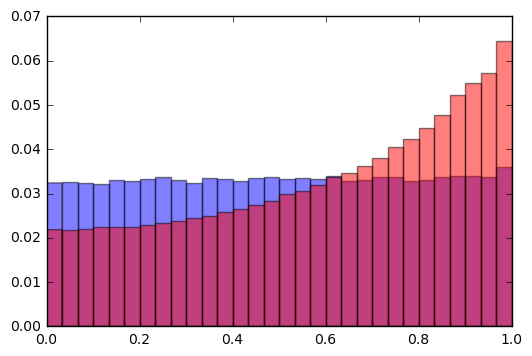

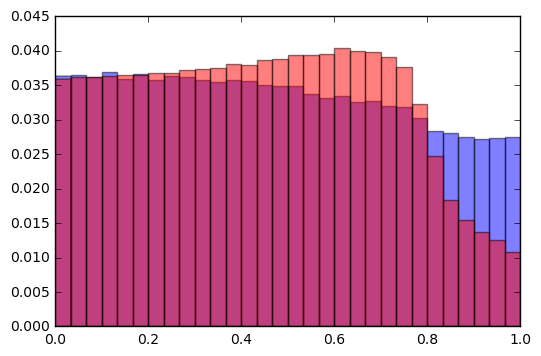

In [46]:
utils.plotting.plot_input_variables(X_sig,X_bkg)

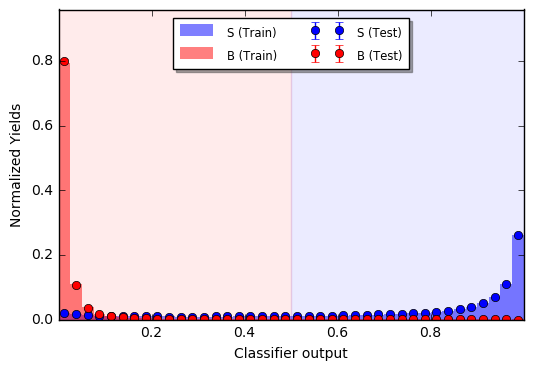

In [47]:
import matplotlib.pyplot as plt

X_total_test = utils.preprocessing.get_total_test_sample(pd.DataFrame(X_sig),pd.DataFrame(X_bkg))
y_total_test = utils.preprocessing.get_total_test_sample(pd.DataFrame(y_sig),pd.DataFrame(y_bkg)).ravel()

utils.plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg")
plt.show()

[ 0.81389666  0.88246191  0.8482157  ...,  0.79742825  0.40997869
  0.78361613]


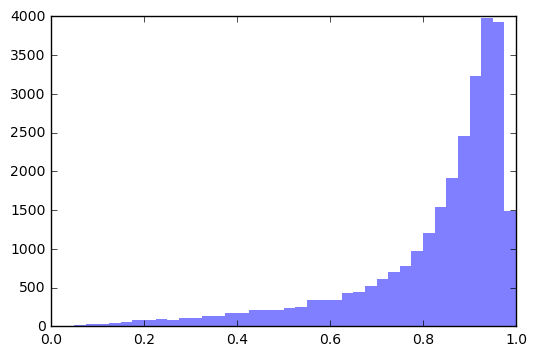

In [48]:
bkg_train = X_total_train[y_total_train == -2]
print clf.predict_proba(bkg_train)[:,1] 
Y_pred_bkg_train = clf.predict_proba(bkg_train)[:,1]

Histo_training_S = np.histogram(Y_pred_bkg_train,bins=40,range=(0,1))
ax1 = plt.subplot(111)

bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])


ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
plt.show()

[ 0.99677533  0.9338457   0.95034254 ...,  0.79748398  0.47218218
  0.96558708]


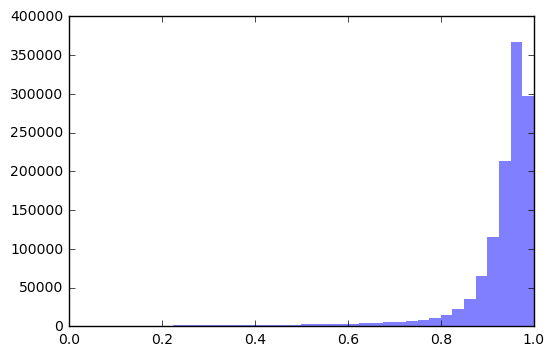

In [49]:
bkg_train = X_total_train[y_total_train == -1]
print clf.predict_proba(bkg_train)[:,1] 
Y_pred_bkg_train = clf.predict_proba(bkg_train)[:,1]

Histo_training_S = np.histogram(Y_pred_bkg_train,bins=40,range=(0,1))
ax1 = plt.subplot(111)

bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])


ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
plt.show()

In [38]:
X = np.array([[1., 0.], [2., 1.], [0., 0.]])
y = np.array([0, 1, 2])
print X
print y
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
y = y[randomize]
print X
print y

[[ 1.  0.]
 [ 2.  1.]
 [ 0.  0.]]
[0 1 2]
[[ 0.  0.]
 [ 2.  1.]
 [ 1.  0.]]
[2 1 0]


In [ ]:
bkg_train = X_total_train[y_total_train == -1]
print clf.predict_proba(bkg_train)[:,0] 
print clf.predict_proba(bkg_train)[:,1] 
print clf.predict_proba(bkg_train)[:,2] 